In [11]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 21.8 MB/s eta 0:00:00 0:00:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 28.7 MB/s eta 0:00:00a 0:00:01
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
None

Sample of the data:
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6

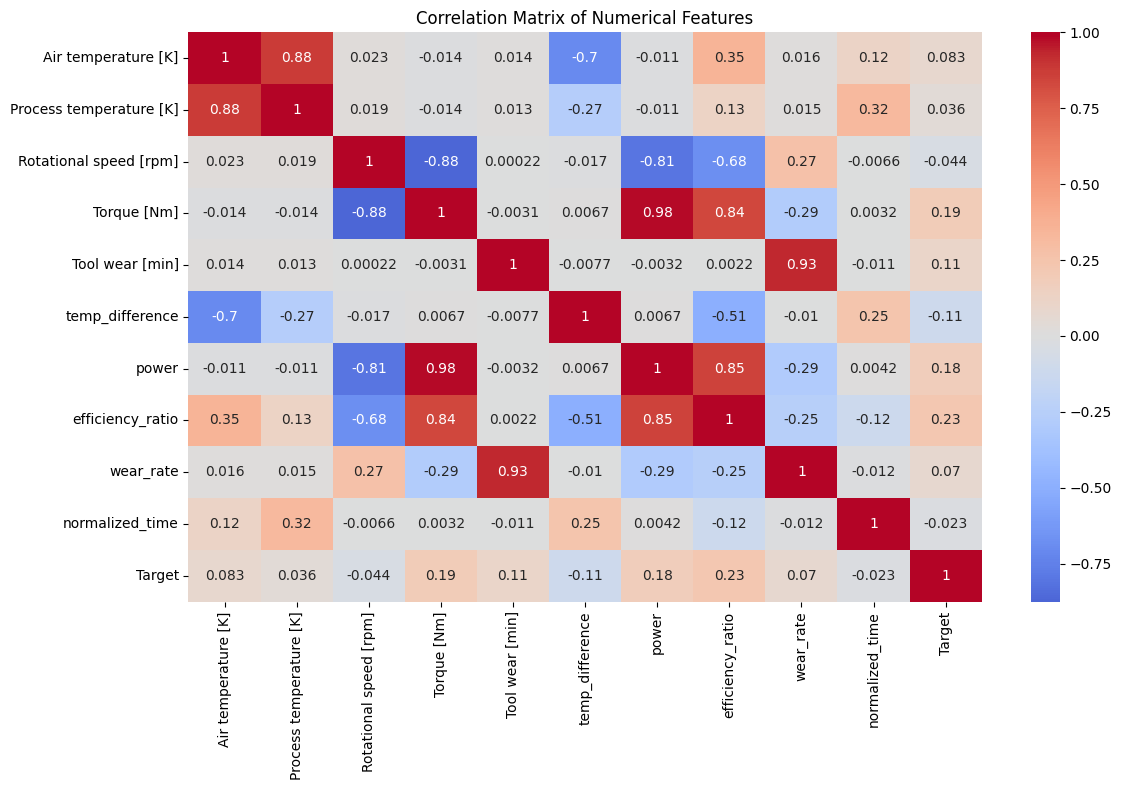

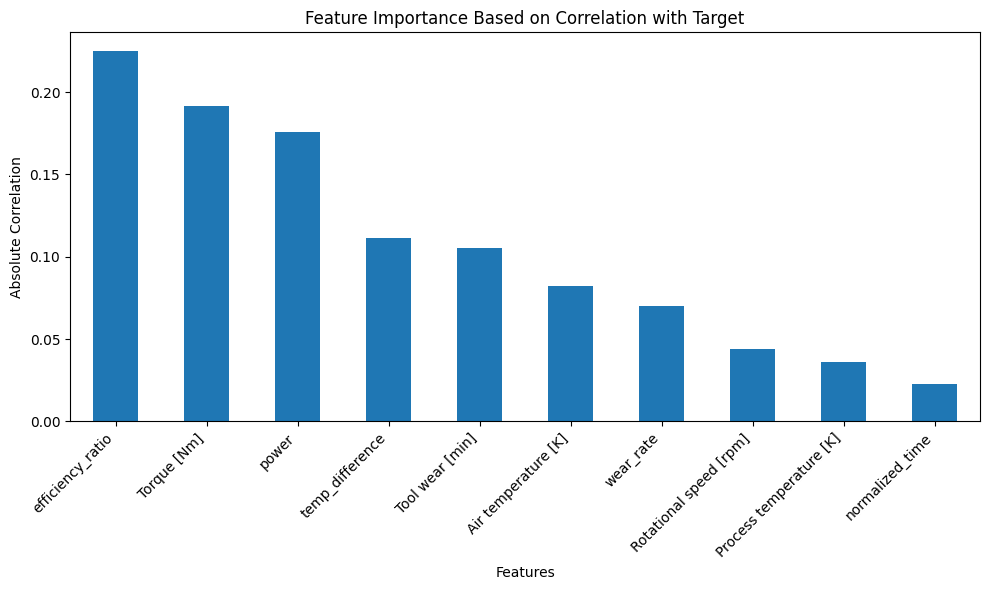


Training set shape: (8000, 18)
Testing set shape: (2000, 18)

Engineered Features Summary:

New features created:
- temp_difference: Temperature differential between process and air
- power: Calculated power based on torque and rotational speed
- efficiency_ratio: Power output relative to temperature difference
- wear_rate: Tool wear per unit of power
- normalized_time: Normalized time sequence from UDI
- Product_ID_encoded: Encoded product ID
- Type_encoded: Encoded machine type
- Failure type dummy variables

Preprocessed data has been saved to 'preprocessed_train.csv' and 'preprocessed_test.csv'


In [14]:
# Feature Engineering and Preprocessing for Predictive Maintenance

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and Initial Exploration
df = pd.read_csv('/Users/akashgodbole/Desktop/Akash/Projects/predictive-maintenance/data/raw/predictive_maintenance.csv')

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())

print("\nSample of the data:")
print(df.head())

print("\nBasic statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# 2. Feature Engineering

# Temperature difference (process vs air)
df['temp_difference'] = df['Process temperature [K]'] - df['Air temperature [K]']

# Power calculation (Torque × Rotational speed)
df['power'] = df['Torque [Nm]'] * df['Rotational speed [rpm]'] / 9550  # Power in kW

# Efficiency ratio (Power output / Temperature difference)
df['efficiency_ratio'] = df['power'] / df['temp_difference']

# Tool wear rate (wear per unit of power)
df['wear_rate'] = df['Tool wear [min]'] / df['power']

# Create time-based features from UDI (assuming it's sequential)
df['normalized_time'] = (df['UDI'] - df['UDI'].min()) / (df['UDI'].max() - df['UDI'].min())

# 3. Categorical Feature Encoding

# Encode Product ID
le_product = LabelEncoder()
df['Product_ID_encoded'] = le_product.fit_transform(df['Product ID'])

# Encode Type
le_type = LabelEncoder()
df['Type_encoded'] = le_type.fit_transform(df['Type'])

# Create dummy variables for Failure Type
failure_type_dummies = pd.get_dummies(df['Failure Type'], prefix='failure')
df = pd.concat([df, failure_type_dummies], axis=1)

# 4. Feature Scaling

# Select numerical columns for scaling (including Target for correlation analysis)
numeric_columns = ['Air temperature [K]', 'Process temperature [K]', 
                  'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
                  'temp_difference', 'power', 'efficiency_ratio', 'wear_rate',
                  'normalized_time', 'Target']

# Initialize scaler
scaler = StandardScaler()

# Scale numerical features
df_scaled = df.copy()
df_scaled[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# 5. Feature Analysis and Visualization

# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df_scaled[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Feature importance visualization (using correlation with target)
# Remove target from features for importance calculation
feature_importance = abs(correlation_matrix['Target'].drop('Target')).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance Based on Correlation with Target')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 6. Train-Test Split

# Separate features and target
X = df_scaled.drop(['Target', 'Failure Type', 'UDI', 'Product ID', 'Type'], axis=1)
y = df_scaled['Target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# 7. Summary of Engineered Features

print("\nEngineered Features Summary:")
print("\nNew features created:")
print("- temp_difference: Temperature differential between process and air")
print("- power: Calculated power based on torque and rotational speed")
print("- efficiency_ratio: Power output relative to temperature difference")
print("- wear_rate: Tool wear per unit of power")
print("- normalized_time: Normalized time sequence from UDI")
print("- Product_ID_encoded: Encoded product ID")
print("- Type_encoded: Encoded machine type")
print("- Failure type dummy variables")

# 8. Export Preprocessed Data
X_train.to_csv('preprocessed_train.csv', index=False)
X_test.to_csv('preprocessed_test.csv', index=False)

print("\nPreprocessed data has been saved to 'preprocessed_train.csv' and 'preprocessed_test.csv'")

In [16]:
%pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


   Torque [Nm]     power  efficiency_ratio  Type_encoded  \
0    -0.891505 -0.952609         -1.164301             1   
1     1.385683  1.442937          1.048065             1   
2    -0.891505 -1.221118         -0.918309             1   
3    -0.700903 -0.706410         -0.603219             2   
4    -0.610618 -0.658346         -0.169953             1   

   failure_Heat Dissipation Failure  failure_No Failure  \
0                             False                True   
1                             False                True   
2                             False                True   
3                             False                True   
4                             False                True   

   failure_Overstrain Failure  failure_Power Failure  failure_Random Failures  \
0                       False                  False                    False   
1                       False                  False                    False   
2                       False            

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Random Forest CV ROC-AUC: 0.503 (+/- 0.034)

Training Gradient Boosting...
Gradient Boosting CV ROC-AUC: 0.484 (+/- 0.083)

Training AdaBoost...


/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



AdaBoost CV ROC-AUC: 0.482 (+/- 0.070)

Training SVM...


/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



SVM CV ROC-AUC: 0.476 (+/- 0.029)

Training Naive Bayes...
Naive Bayes CV ROC-AUC: 0.492 (+/- 0.071)

Model Performance Comparison:
                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression    0.9740   0.000000  0.000000  0.000000  0.509142
Random Forest          0.9740   0.000000  0.000000  0.000000  0.440901
Gradient Boosting      0.9725   0.000000  0.000000  0.000000  0.459056
AdaBoost               0.9740   0.000000  0.000000  0.000000  0.486929
SVM                    0.9740   0.000000  0.000000  0.000000  0.546655
Naive Bayes            0.0460   0.025562  0.961538  0.049801  0.473790


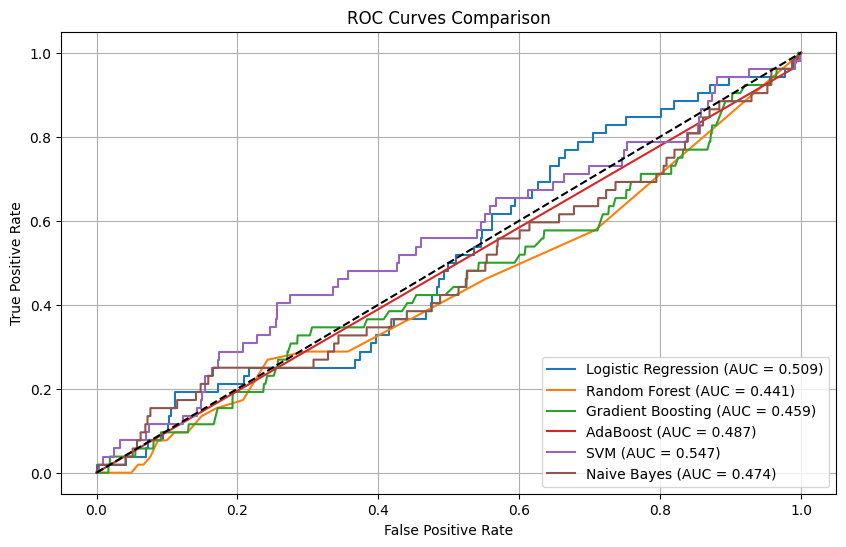

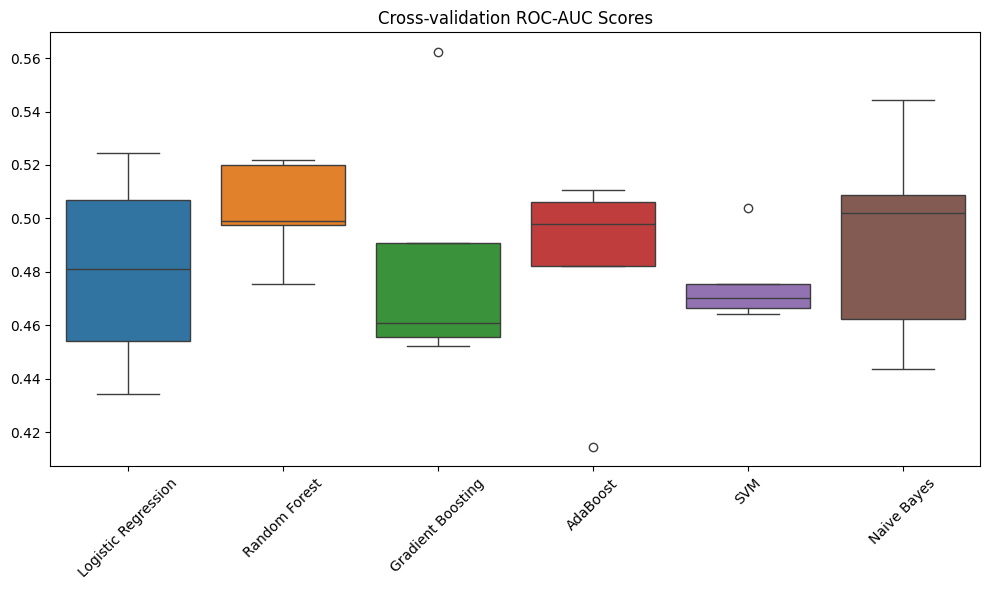

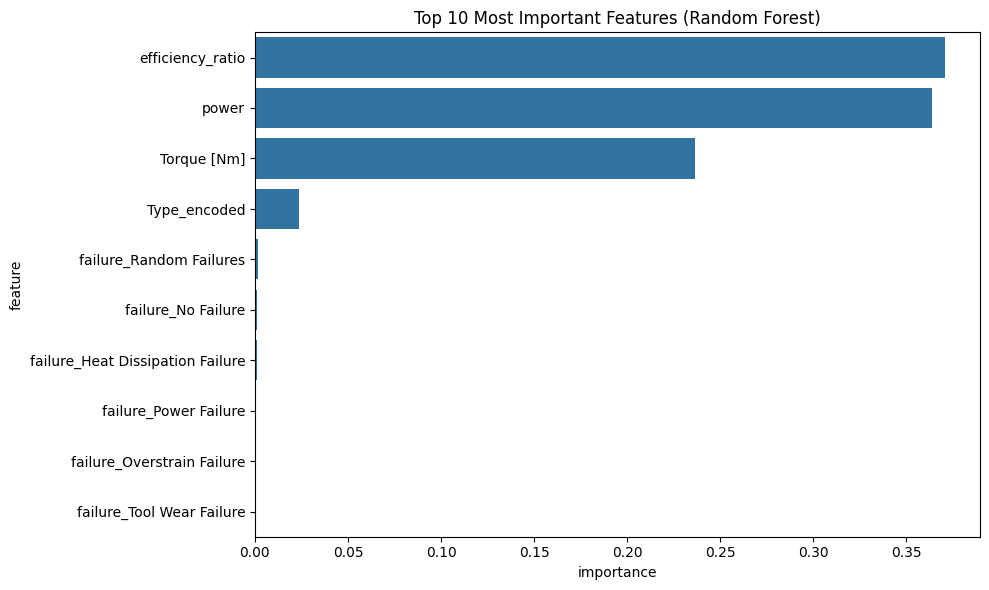


Detailed Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1948
           1       0.00      0.00      0.00        52

    accuracy                           0.97      2000
   macro avg       0.49      0.50      0.49      2000
weighted avg       0.95      0.97      0.96      2000



/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



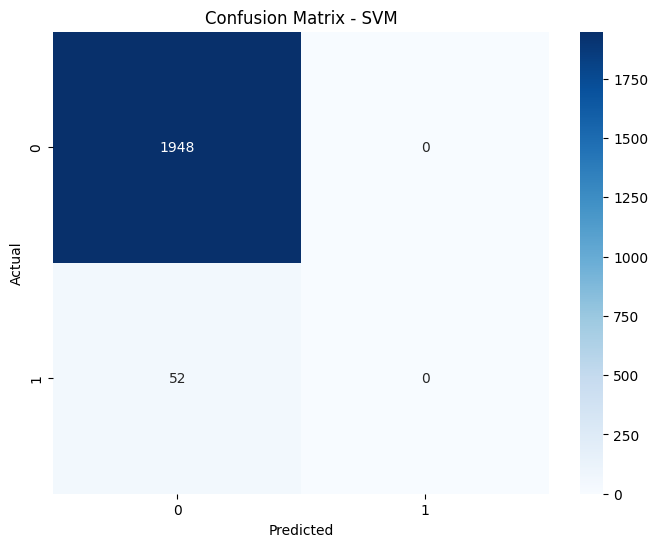


Best Model Performance Summary:
      Metric     Score
0   Accuracy  0.974000
1  Precision  0.000000
2     Recall  0.000000
3   F1 Score  0.000000
4    ROC AUC  0.546655


In [ ]:
# Machine Learning Model Comparison for Predictive Maintenance

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Import various models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.naive_bayes import GaussianNB

# Load the preprocessed data
X_train = pd.read_csv('/Users/akashgodbole/Desktop/Akash/Projects/predictive-maintenance/notebooks/preprocessed_train.csv')
X_test = pd.read_csv('/Users/akashgodbole/Desktop/Akash/Projects/predictive-maintenance/notebooks/preprocessed_test.csv')
y_train = pd.read_csv('/Users/akashgodbole/Desktop/Akash/Projects/predictive-maintenance/data/raw/predictive_maintenance.csv')['Target'].iloc[X_train.index]
y_test = pd.read_csv('/Users/akashgodbole/Desktop/Akash/Projects/predictive-maintenance/data/raw/predictive_maintenance.csv')['Target'].iloc[X_test.index]

X_train = X_train[['Torque [Nm]', 'power', 'efficiency_ratio']]
X_test = X_test[['Torque [Nm]', 'power', 'efficiency_ratio']]
# X_train.drop(['Air temperature [K]', 'Process temperature [K]', 
#                   'Rotational speed [rpm]', 'Tool wear [min]',
#                   'temp_difference', 'wear_rate',
#                   'normalized_time', 'Product_ID_encoded'], axis=1, inplace=True)
# X_test.drop(['Air temperature [K]', 'Process temperature [K]', 
#                   'Rotational speed [rpm]', 'Tool wear [min]',
#                   'temp_difference', 'wear_rate',
#                   'normalized_time', 'Product_ID_encoded'], axis=1, inplace=True)


print(X_train.head(5))

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'Naive Bayes': GaussianNB()
}

# Function to evaluate models
def evaluate_model(y_true, y_pred, y_prob):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_prob)
    }

# Dictionary to store results
results = {}
cv_results = {}
trained_models = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    cv_results[name] = cv_scores
    
    # Train model on full training set
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Store results
    results[name] = evaluate_model(y_test, y_pred, y_prob)
    
    print(f"{name} CV ROC-AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Create results DataFrame
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)

# Plot ROC curves
plt.figure(figsize=(10, 6))
for name, model in trained_models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["ROC AUC"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot cross-validation results
plt.figure(figsize=(10, 6))
cv_results_df = pd.DataFrame(cv_results)
sns.boxplot(data=cv_results_df)
plt.title('Cross-validation ROC-AUC Scores')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature importance analysis (using Random Forest)
rf_model = trained_models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features (Random Forest)')
plt.tight_layout()
plt.show()

# Get detailed classification report for best model
best_model_name = results_df['ROC AUC'].idxmax()
best_model = trained_models[best_model_name]
y_pred_best = best_model.predict(X_test)

print(f"\nDetailed Classification Report for {best_model_name}:")
print(classification_report(y_test, y_pred_best))

# Plot confusion matrix for best model
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save best model performance metrics
best_model_results = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'Score': [
        results[best_model_name]['Accuracy'],
        results[best_model_name]['Precision'],
        results[best_model_name]['Recall'],
        results[best_model_name]['F1 Score'],
        results[best_model_name]['ROC AUC']
    ]
})

print("\nBest Model Performance Summary:")
print(best_model_results)